<a href="https://colab.research.google.com/github/edogriba/NAML-2024/blob/main/LAB04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 04

## Support Vector Regression (SVR)

### Objectives

In this exercise, we will implement and train a Support Vector Regression model using JAX and evaluate its performance on synthetic data. We will go through the steps of data generation, model training, and evaluation.



- Generate synthetic data for regression
- Implement SVR using JAX
- Train the SVR model
- Evaluate the model's performance
- Visualize the results


### Step 1: Import Libraries

We will begin by importing the necessary libraries. JAX will be used for numerical computations, NumPy for array manipulations, and Matplotlib for visualization.

In [26]:
import jax
import jax.numpy as jnp
import jax.scipy.optimize

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Step 2: Define the SVR Class

We will create a class `SVR` to encapsulate the SVR model. The class will include methods for calculating the loss, training the model, and making predictions.

#### Loss Function

The loss function for SVR is defined as:

$$ L(w) = \lambda \|w\|^2 + \frac{1}{n} \sum\_{i=1}^{n} \max(0, |f(x_i) - y_i| - \epsilon) $$

Where:

- $ w $ are the model parameters.
- $ \lambda $ is the regularization parameter.
- $ \epsilon $ is the epsilon-insensitive loss threshold.
- $ f(x_i) $ is the predicted value for input \( x_i \).
- $ y_i $ is the actual target value.

Let's define the `SVR` class.


In [63]:
class SVR:
  def __init__(self, epsilon=0.1, lmbda=1.0):
    self.epsilon = epsilon
    self.lmbda = lmbda
    self.w = None

  def loss(self, params, X, y):
    # 1. Compute the y predictions
    predictions = jnp.dot(X, params[:-1]) + params[-1]
    # 2. Compute epsilon insensitive loss
    eps_loss = jnp.maximum(0, jnp.abs(predictions - y) - self.epsilon)
    # 3. Regularization term (L2 norm of w)
    reg = self.lmbda * jnp.sum(params**2)
    # 4. Total loss
    return jnp.mean(eps_loss) + reg

  def train(self, X, y):
    # Initialize weights and bias self.w
    self.w = jnp.zeros(X.shape[1] + 1)

    # Solve optimization problem
    opt_res = jax.scipy.optimize.minimize(self.loss, self.w, method="BFGS", args=(X, y)) # loss is minimized, X and y are not passed to be minimized

    self.w = opt_res.x # point wherethe optimal minimum is achieved

  def predict(self, X):
    # Implement prediction
    return jnp.dot(X, self.w[:-1]) + self.w[-1]

### Step 3: Generate Synthetic Data

Next, we will generate synthetic data for regression. We will create a linear relationship with added Gaussian noise.

- We will generate $ n\_{samples} $ data points.
- The true relationship will follow the equation $ y = mx + c $.
- Gaussian noise will be added to simulate real-world data.


In [64]:
np.random.seed(0)
m = 2.5
c = 1.0
n_samples = 100

X = np.random.uniform(0, 10, size = (n_samples, 1))

noise = np.random.randn(n_samples, 1)

y = m * X + c + noise

y = y.flatten()

### Step 4: Split the Data

Now, we will split the dataset into training and testing sets. This allows us to evaluate the model's performance on unseen data.

We will use an 80-20 split for training and testing.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Convert data to JAX arrays
X_train = jnp.asarray(X_train)
y_train = jnp.asarray(y_train)
X_test = jnp.asarray(X_test)
y_test = jnp.asarray(y_test)

### Step 5: Train the SVR Model

We will now create an instance of the `SVR` class and train the model using the training data.


In [66]:
# First we instantiate

svr = SVR(epsilon=1.0, lmbda=0.1)
svr.train(X_train, y_train)


### Step 6: Make Predictions

After training, we will use the model to make predictions on both the training and testing datasets.


In [67]:
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

### Step 7: Evaluate the Model

We will evaluate the model's performance using the Mean Squared Error (MSE), which is defined as:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

Where:

- $ y_i $ is the actual value.
- $ \hat{y}_i $ is the predicted value.
- $ n $ is the number of samples.


In [68]:
mse_train =jnp.mean((y_train - y_pred_train)**2)
mse_test =jnp.mean((y_test - y_pred_test)**2)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 1.2244
Test MSE: 1.0071


### Step 8: Visualize the Results

Finally, we will visualize the training data, test data, and the model's predictions. This will help us understand how well our model has captured the underlying relationship.


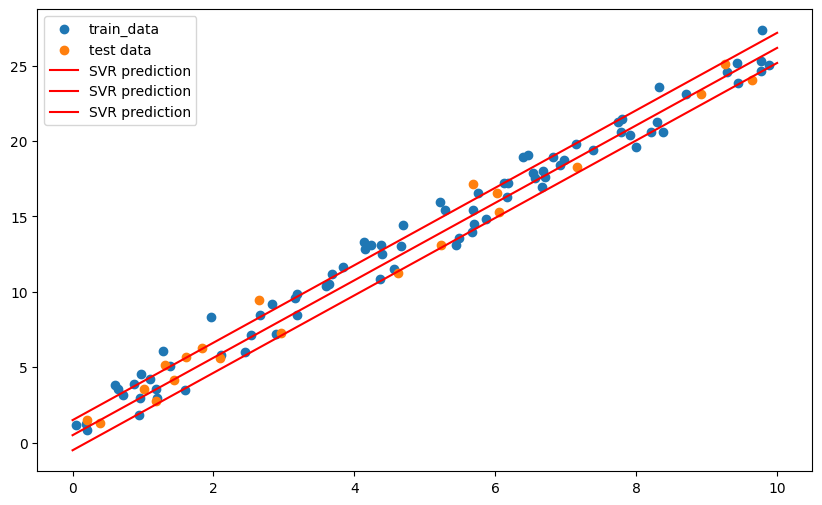

In [69]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train, y_train, label='train_data')

plt.scatter(X_test, y_test, label='test data')

x_range = jnp.linspace(0, 10, 1000).reshape((-1, 1))

y_pred_line = svr.predict(x_range)

plt.plot(x_range, y_pred_line, color='red', label="SVR prediction")

plt.plot(x_range, y_pred_line - svr.epsilon, color='red', label="SVR prediction")

plt.plot(x_range, y_pred_line + svr.epsilon, color='red', label="SVR prediction")

plt.legend()

## Support Vector Machine (SVM)

We will change the previous code to implement a linear Support Vector Machine in primal formulation

### Step 2: Define the SVM Class

We will create a class `SVM` to encapsulate the SVM model. The class will include methods for calculating the loss, training the model, and making predictions.

### Loss Function
The loss function for SVM is defined as the hinge loss:

$$ L(w) = \lambda \|w\|^2 + \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - y_i (w^T x_i + b)) $$

Where:
- $ w $ are the model parameters (weights).
- $ b $ is the bias term.
- $ \lambda $ is the regularization parameter.
- $ y_i $ is the true label for the sample $ i $.
- $ x_i $ is the feature vector for the sample $ i $.
- The first term is the regularization term, and the second term is the hinge loss.

Let's define the `SVM` class.

In [70]:
class SVM:
  def __init__(self, lmbda=1.0):
    self.lmbda = lmbda
    self.w = None

  def loss(self, params, X, y):
      # Compute the predictions
      predictions = jnp.dot(X, params[:-1]) + params[-1]

      # Compute the loss function
      loss_val = jnp.maximum(0, jnp.ones(predictions.size) -  y * predictions)

      reg = self.lmbda * jnp.sum(params ** 2)

      return jnp.mean(loss_val) + reg

  def train(self, X, y):
      # Initialize weights and biases
      self.w = jnp.zeros(X.shape[1] + 1)

      # Solve optimization problem
      opt_res = jax.scipy.optimize.minimize(self.loss, self.w, method="BFGS", args=(X, y))

      self.w = opt_res.x

  def predict(self, X):
      # Decision function
      decision = jnp.dot(X, self.w[:-1]) + self.w[-1]
      return jnp.sign(decision)


### Step 3: Generate Synthetic Classification Data

Next, we will generate synthetic data for classification. We will create a dataset of points in a 2D space and label them based on their coordinates.

- We will generate $ n_{samples} $ data points.
- The labels will be determined by the condition $ x_1 + x_2 > 10 $ to classify points into two categories.

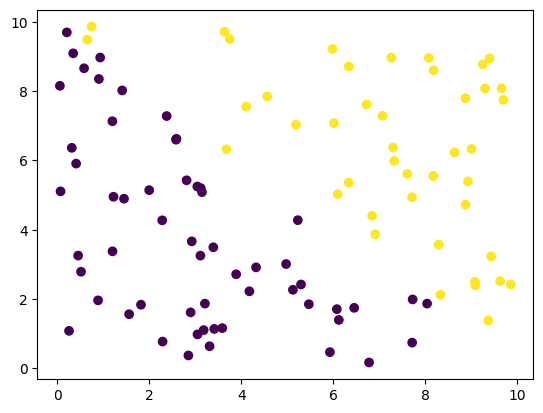

In [71]:
np.random.seed(42)

n_samples = 100

X = np.random.uniform(0, 10, size=(n_samples, 2))

y = np.where(X.sum(axis=1) > 10, 1, -1)

y = y.flatten()

plt.scatter(X[:, 0], X[:, 1], c=y)

### Step 4: Split the Data

Now, we will split the dataset into training and testing sets. This allows us to evaluate the model's performance on unseen data.

We will use an 80-20 split for training and testing.


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to JAX arrays

X_train = jnp.asarray(X_train)
X_test = jnp.asarray(X_test)
y_train = jnp.asarray(y_train)
y_test = jnp.asarray(y_test)

### Step 5: Train the SVM Model

We will now create an instance of the SVM class and train the model using the training data

In [85]:
svm = SVM(lmbda=0.000001) # smallerthan this creates problems
svm.train(X_train, y_train)

### Step 6: Make Predictions

After training, we will use the model to make predictions on both the training and testing datasets.

In [86]:
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

### Step 7: Evaluate the Model

We will evaluate the model's performance using accuracy, which is defined as the proportion of correct predictions:

$$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $$

Let's calculate and print the accuracy for both the training and test sets.

In [87]:
accuracy_train = jnp.mean(y_pred_train == y_train)
accuracy_test = jnp.mean(y_pred_test == y_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9500


### Step 8: Visualize the Results

Finally, we will visualize the training data, test data, and the decision boundary of the SVM model. This will help us understand how well our model has separated the classes.


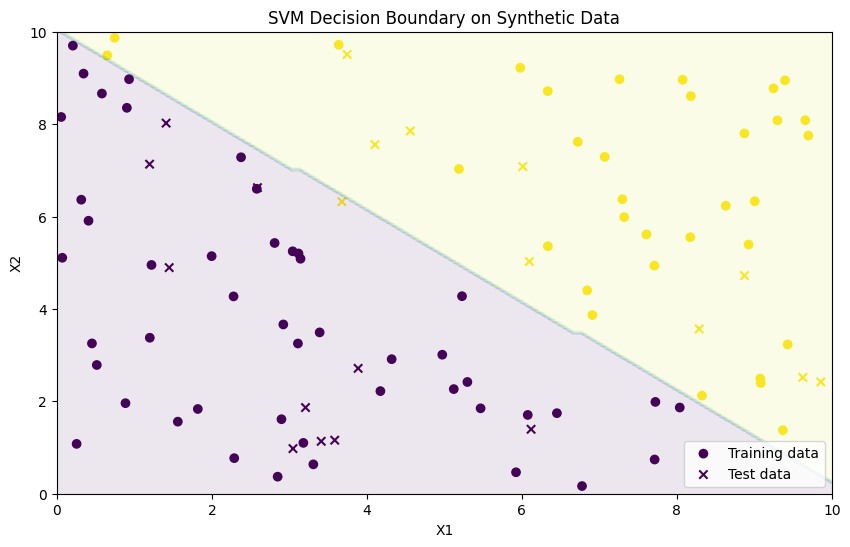

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, label='Training data', marker='o')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='Test data', marker='x')

# Plot the decision boundary
t = np.linspace(0, 10, 100)
xx1, xx2 = np.meshgrid(t, t)
xx = np.stack([xx1.flatten(), xx2.flatten()], axis=1)
yy = svm.predict(xx)
plt.contourf(xx1, xx2, yy.reshape(xx1.shape), alpha=0.1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('SVM Decision Boundary on Synthetic Data')
plt.legend(loc="lower right")
plt.show()